In [13]:
# !pip install -U numpy pandas scikit-learn matplotlib seaborn \
#     torch torchvision torchaudio \
#     scikit-optimize \
#     skorch \
#     xgboost \
#     joblib
!pip install --no-cache-dir -U \
    numpy pandas scikit-learn matplotlib seaborn \
    torch torchvision torchaudio \
    xgboost scikit-optimize skorch \
    joblib tqdm


!pip install --no-cache-dir -U skorch==0.15.*


!pip uninstall -y torch torchvision torchaudio

!pip install --no-cache-dir \
  torch==2.3.1+cpu \
  torchvision==0.18.1+cpu \
  torchaudio==2.3.1+cpu \
  -f https://download.pytorch.org/whl/torch_stable.html

!pip install tqdm




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 114.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 112.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 119.3 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.0
    Uninstalling joblib-1.5.0:
      Successfully uninstalled joblib-1.5.0
  Attempting uninstall: torch━━━━━━━━━━━━━━━━━━━ 0/5 [joblib]
    Found existing installation: torch 2.3.1+cpu 0/5 [joblib]
    Uninstalling torch-2.3.1+cpu:0m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/5 [torch]
      Successfully uninstalled torch-2.3.1+cpu━━━━━━━━━━━━━━━━━━━━ 1/5 [torch]
  Attempting uninstall: skorch━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/5 [torch]
    Found existing installation: skorch 0.15.0━━━━━━━━━━━━━━━━ 1/5 [torch]
    Uninstalling skorch-0.15.0:━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/5 [torch]
      Successfully uninstalled skorch-0.15.0━━━━━━━━━━━━━━━━━━ 1/5 [torch]
  Attempting uninsta

In [49]:
# =========================================================
# Section 0 ─ Kafka 连接参数 & 消费 + 生产函数
# =========================================================
from kafka import KafkaConsumer, KafkaProducer
import json, time, threading, queue
import pandas as pd
import numpy as np

KAFKA_TOPIC   = "latencyTopic"                 # ↔ 原 csv 里的数据
KAFKA_SERVERS = ["kafka.default.svc.cluster.local:9092"]

BATCH_SIZE    = 200        # 一次攒 60 就够后续演示
CONSUME_TIMEOUT_SEC = 100  # Demo 环境 1 min

feature_cols   = None
TARGET_COL     = "output_rate"
EXCLUDE_COLS   = ["Unnamed: 0", "input_rate", "output_rate", "latency"]

_stream_q = queue.Queue()

# ---------- ① Consumer 线程 ----------
def _kafka_consume_worker():
    consumer = KafkaConsumer(
        KAFKA_TOPIC,
        bootstrap_servers=KAFKA_SERVERS,
        group_id=f"drift-demo-{int(time.time())}",
        auto_offset_reset="earliest",
        enable_auto_commit=True,
        value_deserializer=lambda m: json.loads(m.decode("utf-8")),
    )
    for msg in consumer:
        _stream_q.put(msg.value)
        if _stream_q.qsize() >= BATCH_SIZE:
            break
    consumer.close()

threading.Thread(target=_kafka_consume_worker, daemon=True).start()
print("🚀 Kafka consumer started, waiting for batch...")

# ---------- ② Producer 线程（直接把 csv 打进 Kafka） ----------
def _producer_worker():
    # 用你 Section 3 里本来就要读的 4 个 csv 之一当作流——通常选 Dag-1
    path_stream = 'datasets/dag-1/resource_stimulus_global_A-B-C.csv'
    df_stream = (
        pd.read_csv(path_stream, index_col=0)
          .replace({'<not counted>': np.nan, ' ': np.nan})
          .dropna()
          .reset_index(drop=True)
    )

    prod = KafkaProducer(bootstrap_servers=",".join(KAFKA_SERVERS))
    fcols = FEATURE_COLS          # 和训练保持完全一致

    for idx, row in df_stream.iterrows():
        msg = {
            "row_index": idx,
            "features": {c: float(row[c]) for c in fcols},
            "label":    float(row[TARGET_COL])
        }
        prod.send(KAFKA_TOPIC, json.dumps(msg).encode("utf-8"))

        # 控制发送速度：每 0.05 s 一条，约 20 TPS
        time.sleep(0.05)

    prod.flush()
    prod.close()
    print("✅ Producer finished sending all rows.")



🚀 Kafka consumer started, waiting for batch...


In [50]:
# =========================================================
# Section 1 ─ 依赖导入 & 随机数种子
# =========================================================
import os, sys, re, time, itertools, random, warnings
os.environ["TORCH_DISABLE_DYNAMO"] = "1"
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from tqdm import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping
from skopt import BayesSearchCV
from scipy.spatial.distance import jensenshannon

# 设置随机数种子，确保复现性
SEED = 40
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# =========================================================
# Section 2 ─ 工具函数（评估指标 + JS 散度 + 筛选）
# =========================================================
def calculate_accuracy_within_threshold(y_true, y_pred, threshold: float) -> float:
    dist = np.abs(y_true - y_pred) / y_true
    return (dist <= threshold).mean() * 100

def js_divergence(p, q):
    return jensenshannon(p, q) ** 2

def calculate_js_divergence_between_datasets(df1, df2, feats, bins=30):
    diver = {}
    for f in feats:
        if f in df1.columns and f in df2.columns:
            lo, hi = min(df1[f].min(), df2[f].min()), max(df1[f].max(), df2[f].max())
            p, _ = np.histogram(df1[f], bins=bins, range=(lo, hi), density=True)
            q, _ = np.histogram(df2[f], bins=bins, range=(lo, hi), density=True)
            diver[f] = js_divergence(p, q)
    return diver

# ---------- ★★ TF 版筛选逻辑复刻 ----------
def filter_predictions(y_true, y_pred, threshold=0.1, accurate=True):
    err = np.abs(y_true - y_pred) / y_true
    mask = err <= threshold if accurate else err > threshold
    return y_pred[mask], y_true[mask], np.where(mask)[0]

def filter_min(y_true, y_pred, min_value=500):
    mask = y_true >= min_value
    return y_pred[mask], y_true[mask], np.where(mask)[0]

# =========================================================
# Section 3 ─ 数据加载 & JS Divergence
# =========================================================
# 设置数据路径
path1 = 'datasets/dag-1/resource_stimulus_global_A-B-C.csv'
path2 = 'datasets/dag-2/resource_stimulus_global_A-B-C.csv'
path3 = 'datasets/linear/resource_stimulus_global_A-B-C_modified.csv'
path4 = 'datasets/total/resource_stimulus_global_A-B-C_modified.csv'

# 替换非法值并读取
replace_vals = {'<not counted>': np.nan, ' ': np.nan}
data_dag1   = pd.read_csv(path1, index_col=0).replace(replace_vals).dropna()
data_dag2   = pd.read_csv(path2, index_col=0).replace(replace_vals).dropna()
data_linear = pd.read_csv(path3, index_col=0).replace(replace_vals).dropna()
data_bridge = pd.read_csv(path4, index_col=0).replace(replace_vals).dropna()

# 计算四个数据集的公共列名（除 output_rate）
common_cols = set(data_dag1.columns) & set(data_dag2.columns) & set(data_linear.columns) & set(data_bridge.columns)
common_cols = list(common_cols - {'output_rate'})

FEATURE_COLS = [
    c for c in data_bridge.columns          # 只用在 Bridge 中出现的列
    if c not in EXCLUDE_COLS + [TARGET_COL] # 去掉 input_rate / latency / output_rate
]
print(f"特征列数: {len(FEATURE_COLS)}")

# 提取 CPU 相关特征列（供 JS 使用，无需参与训练）
cpu_feats = [
    c for c in data_bridge.columns
    if any(key in c for key in ('instructions', 'cycles', 'cache', 'branches')) and
       c not in ('input_rate', 'output_rate', 'latency')
]

# JS Divergence 示例
js = calculate_js_divergence_between_datasets(data_dag1, data_dag2, cpu_feats)
print(f"平均 JS Divergence = {np.mean(list(js.values())):.3f}")

# ✅ ★★ Section 3 最关键一行：定义 FEATURE_COLS（供训练 & 流处理共用）★★
FEATURE_COLS = [c for c in data_bridge.columns if c not in EXCLUDE_COLS + [TARGET_COL]]
print("FEATURE_COLS =", FEATURE_COLS)

# ✅ ★★ 现在才启动 Producer 线程 ★★
threading.Thread(target=_producer_worker, daemon=True).start()

特征列数: 60
平均 JS Divergence = 0.209
FEATURE_COLS = ['firewall_instructions', 'nf_router_instructions', 'ndpi_stats_instructions', 'payload_scan_instructions', 'bridge_instructions', 'firewall_branches', 'nf_router_branches', 'ndpi_stats_branches', 'payload_scan_branches', 'bridge_branches', 'firewall_branch-misses', 'nf_router_branch-misses', 'ndpi_stats_branch-misses', 'payload_scan_branch-misses', 'bridge_branch-misses', 'firewall_branch-load-misses', 'nf_router_branch-load-misses', 'ndpi_stats_branch-load-misses', 'payload_scan_branch-load-misses', 'bridge_branch-load-misses', 'firewall_cache-misses', 'nf_router_cache-misses', 'ndpi_stats_cache-misses', 'payload_scan_cache-misses', 'bridge_cache-misses', 'firewall_cache-references', 'nf_router_cache-references', 'ndpi_stats_cache-references', 'payload_scan_cache-references', 'bridge_cache-references', 'firewall_cycles', 'nf_router_cycles', 'ndpi_stats_cycles', 'payload_scan_cycles', 'bridge_cycles', 'firewall_L1-dcache-load-misses', '

In [51]:
# =========================================================
# Section 4 ─ 标准化 + PCA
# =========================================================
scaler = StandardScaler().fit(data_bridge[FEATURE_COLS])
bridge_scaled = scaler.transform(data_bridge[FEATURE_COLS])
dag1_scaled   = scaler.transform(data_dag1  [FEATURE_COLS])


pca_full = PCA().fit(bridge_scaled)
n_components = np.where(np.cumsum(pca_full.explained_variance_ratio_) >= .85)[0][0] + 1
print("PCA n_components =", n_components)

pca = PCA(n_components=n_components).fit(bridge_scaled)
bridge_pca = pca.transform(bridge_scaled)
dag1_pca   = pca.transform(dag1_scaled)

cols_pca = [f"PC{i+1}" for i in range(n_components)]
df_bridge = pd.DataFrame(bridge_pca, columns=cols_pca)
df_bridge["output_rate"] = data_bridge["output_rate"].values
df_dag1   = pd.DataFrame(dag1_pca,   columns=cols_pca)
df_dag1["output_rate"]   = data_dag1["output_rate"].values

PCA n_components = 6


In [52]:
# =========================================================
# Section 5 ─ 基线 MLP（PyTorch）
# =========================================================
class MLP(nn.Module):
    def __init__(self, in_dim, hidden1=32, hidden2=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 1),
        )
    def forward(self, x):
        return self.net(x).squeeze(1)

def train_mlp(X_tr, y_tr, X_val, y_val, lr=1e-2, epochs=10, batch=4):
    dev   = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = MLP(X_tr.shape[1]).to(dev)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    ds = TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr))
    dl = DataLoader(ds, batch_size=batch, shuffle=True)
    for _ in range(epochs):
        model.train()
        for xb, yb in dl:
            xb, yb = xb.to(dev), yb.to(dev)
            pred   = model(xb)
            loss   = loss_fn(pred, yb)
            opt.zero_grad(); loss.backward(); opt.step()
    model.eval()
    with torch.no_grad():
        y_hat = model(torch.from_numpy(X_val).to(dev)).cpu().numpy()
    return model, y_hat

# ---- ⚠️ 训练、验证、后续全部使用 “PCA 压缩后的列” ----
Xb = df_bridge[cols_pca].values.astype(np.float32)
yb = df_bridge["output_rate"].values.astype(np.float32)
X_tr, X_val, y_tr, y_val = train_test_split(
    Xb, yb, test_size=.3, random_state=SEED
)

model_base, y_pred_val = train_mlp(X_tr, y_tr, X_val, y_val)
thr = .15
print("Baseline acc (val):",
      calculate_accuracy_within_threshold(y_val, y_pred_val, thr))

Xd1 = df_dag1[cols_pca].values.astype(np.float32)
yd1 = df_dag1["output_rate"].values.astype(np.float32)
with torch.no_grad():
    y_pred_dag1_base = model_base(torch.from_numpy(Xd1)).cpu().numpy()
print("Acc on Dag-1 (base):",
      calculate_accuracy_within_threshold(yd1, y_pred_dag1_base, thr))


Baseline acc (val): 68.00595238095238
Acc on Dag-1 (base): 27.725437415881558


In [53]:
# =========================================================
# Section 6 ─ 从流数据取一批 → 判断漂移 → (可选) GridSearch
# =========================================================
CONSUME_TIMEOUT_SEC = 300       # 如需更长等待可再调大
stream_rows = []
while len(stream_rows) < BATCH_SIZE:
    try:
        row = _stream_q.get(timeout=CONSUME_TIMEOUT_SEC)
        stream_rows.append(row)
    except queue.Empty:
        raise RuntimeError(f"等了 {CONSUME_TIMEOUT_SEC}s 只收够 {len(stream_rows)} 条")

# ---------- 1️⃣ 组装 DataFrame ----------
df_stream = pd.DataFrame(
    [{
        **{c: r["features"][c] for c in FEATURE_COLS},
        TARGET_COL: r["label"]
    } for r in stream_rows]
).reindex(columns=FEATURE_COLS + [TARGET_COL])     # 固定列顺序

stream_X_raw = df_stream[FEATURE_COLS].values.astype(np.float32)
stream_y     = df_stream[TARGET_COL].values.astype(np.float32)

# ---------- 2️⃣ Scaler + PCA ----------
stream_X_scaled = scaler.transform(df_stream[FEATURE_COLS])
stream_X_pca    = pca.transform(stream_X_scaled).astype(np.float32)  # 保证 float32

# ---------- 3️⃣ 旧模型推理 ----------
with torch.no_grad():
    y_pred_stream_base = model_base(torch.from_numpy(stream_X_pca)).cpu().numpy()

# ---------- 4️⃣ 判漂移 ----------
thr       = 0.15
acc_base  = calculate_accuracy_within_threshold(y_val, y_pred_val, thr)
acc_stream= calculate_accuracy_within_threshold(stream_y, y_pred_stream_base, thr)
print(f"Baseline acc: {acc_base:.2f}% | Stream acc: {acc_stream:.2f}%")

need_retrain = acc_base - acc_stream > 5

if need_retrain:
    print("⚠️ 触发漂移：启动 GridSearch 重训练…")

    net = NeuralNetRegressor(
        module               = MLP,
        module__in_dim       = X_tr.shape[1],
        max_epochs           = 100,
        lr                   = 0.1,
        batch_size           = 8,
        optimizer            = torch.optim.Adam,
        criterion            = nn.MSELoss,
        iterator_train__shuffle = True,
        callbacks            = [EarlyStopping(patience=10)],
        device               = 'cuda' if torch.cuda.is_available() else 'cpu',
        verbose              = 0,
    )

    param_grid = {
        "lr": [0.1, 0.01, 0.001],
        "module__hidden1": [16, 32, 64],
        "module__hidden2": [8, 16, 32],
        "batch_size": [8, 16, 32],
    }

    gs = GridSearchCV(
        estimator = net,
        param_grid= param_grid,
        cv        = 3,
        n_jobs    = -1,
        scoring   = "neg_mean_squared_error",
        verbose   = 2                 # ← 进度条 / 日志
    )
    gs.fit(X_tr, y_tr)

    best_net = gs.best_estimator_
    with torch.no_grad():
        y_pred_stream_new = best_net.predict(stream_X_pca)

    acc_new = calculate_accuracy_within_threshold(stream_y, y_pred_stream_new, thr)
    print(f"✅ 重训练完成，新模型在流数据上精度: {acc_new:.2f}%")
else:
    print("✅ 模型表现稳定，无需重训练。")
    best_net = NeuralNetRegressor(module=MLP, module__in_dim=X_tr.shape[1])
    best_net.module_ = model_base
    y_pred_stream_new = y_pred_stream_base

# ---------- 5️⃣ 暴露给 Section 7 ----------
Xd1_pca_global = stream_X_pca             # 60×n_components
yd1_global     = stream_y
y_pred_dag1_new = y_pred_stream_new       # 供后续拼接


Baseline acc: 68.01% | Stream acc: 13.33%
⚠️ 触发漂移：启动 GridSearch 重训练…
Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END batch_size=8, lr=0.1, module__hidden1=16, module__hidden2=8; total time=   3.6s
[CV] END batch_size=8, lr=0.1, module__hidden1=16, module__hidden2=8; total time=   4.2s
[CV] END batch_size=8, lr=0.1, module__hidden1=16, module__hidden2=8; total time=   5.0s
[CV] END batch_size=8, lr=0.1, module__hidden1=16, module__hidden2=16; total time=   5.2s
[CV] END batch_size=8, lr=0.1, module__hidden1=16, module__hidden2=16; total time=   5.7s
[CV] END batch_size=8, lr=0.1, module__hidden1=16, module__hidden2=32; total time=   6.8s
[CV] END batch_size=8, lr=0.1, module__hidden1=16, module__hidden2=32; total time=   7.6s
[CV] END batch_size=8, lr=0.1, module__hidden1=32, module__hidden2=8; total time=   3.7s
[CV] END batch_size=8, lr=0.1, module__hidden1=16, module__hidden2=32; total time=   5.1s
[CV] END batch_size=8, lr=0.1, module__hidden1=16, module__hidd

In [57]:
# =========================================================
# Section 7 ─ 拼接 → 取 index_range → filter_min
# =========================================================
correction_offset = 38
join_index        = len(df_bridge)
thr               = .10

# ---------- 1️⃣ 旧模型预测 ----------
with torch.no_grad():
    bridge_pred_orig = model_base(torch.from_numpy(Xb)).cpu().numpy()
    dag1_pred_orig   = model_base(torch.from_numpy(Xd1_pca_global)).cpu().numpy()

# ---------- 2️⃣ 新模型预测 + 过滤 ----------
pred_good, true_good, idx_good = filter_predictions(
    yd1_global, y_pred_dag1_new, threshold=thr, accurate=True
)

# ---------- 3️⃣ 拼接（绿色曲线） ----------
dag1_part = np.concatenate([
    dag1_pred_orig[:min(correction_offset, len(dag1_pred_orig))],
    pred_good
])
y_pred_adjusted_full = np.concatenate([bridge_pred_orig, dag1_part])

# ---------- 4️⃣ 真实值同样拼接 ----------
y_true_adjusted_full = np.concatenate([yb, true_good])

# ---------- 5️⃣ 原始预测拼接（红线） ----------
y_pred_original_full = np.concatenate([bridge_pred_orig, dag1_pred_orig])

# ---------- 6️⃣ index_range ----------
full_len = len(y_true_adjusted_full)
index_start = max(0, join_index - 70)
index_end   = min(full_len, join_index + 130)
index_range = np.arange(index_start, index_end)

y_pred_selected          = y_pred_original_full [index_range]
y_pred_selected_adjusted = y_pred_adjusted_full [index_range]
y_selected_adjusted      = y_true_adjusted_full[index_range]

y_pred_selected_adjusted, y_selected_adjusted, ad_ind = (
    filter_min(y_selected_adjusted, y_pred_selected_adjusted, min_value=500)
)
y_pred_selected = y_pred_selected[ad_ind]

# ---------- 7️⃣ 自动标注 ----------
thr_drift = 0.15
err_ratio = np.abs(yd1_global - y_pred_stream_base) / yd1_global
first_bad = int(np.argmax(err_ratio > thr_drift))
drift_global = join_index + first_bad
plot_shift   = join_index - 70

inject_plot     = drift_plot = drift_global - plot_shift
correction_plot = drift_plot + min(correction_offset, len(dag1_pred_orig))


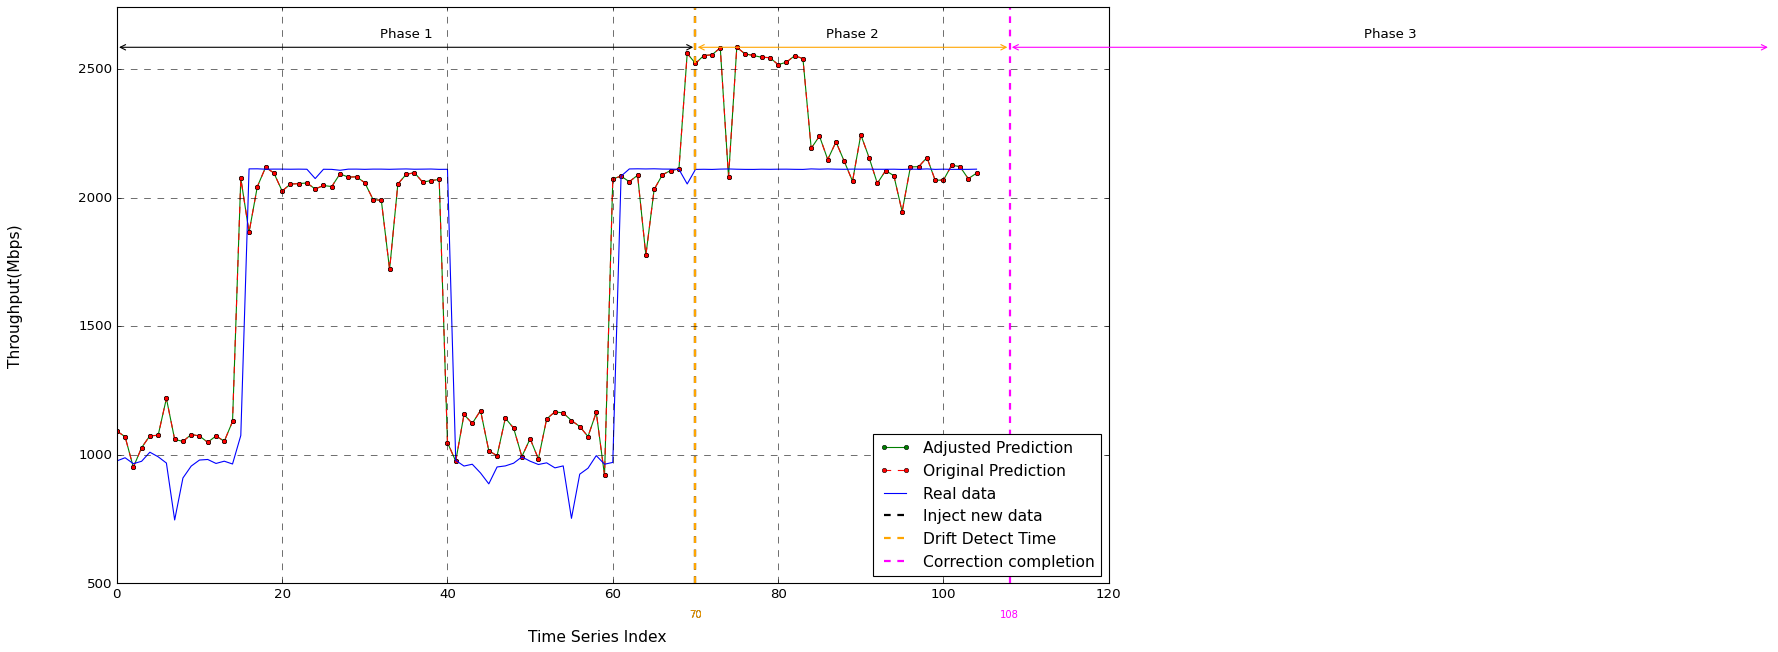

[CV] END batch_size=32, lr=0.001, module__hidden1=64, module__hidden2=8; total time=   3.8s
[CV] END batch_size=32, lr=0.001, module__hidden1=64, module__hidden2=16; total time=   3.8s
[CV] END batch_size=32, lr=0.001, module__hidden1=64, module__hidden2=16; total time=   3.8s
[CV] END batch_size=32, lr=0.001, module__hidden1=64, module__hidden2=16; total time=   3.7s
[CV] END batch_size=32, lr=0.001, module__hidden1=64, module__hidden2=32; total time=   3.7s
[CV] END batch_size=32, lr=0.001, module__hidden1=64, module__hidden2=32; total time=   3.7s
[CV] END batch_size=32, lr=0.001, module__hidden1=64, module__hidden2=32; total time=   3.4s


In [60]:
# =========================================================
# Section 8 ─ 终极绘图（自动标注三阶段 & 三条曲线）
# =========================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.style.use("classic")

fig, ax = plt.subplots(facecolor="white", figsize=(16, 9))
ax.set_facecolor("white")

# ---------------- ① 横坐标范围 ----------------
index_range = np.arange(len(y_pred_selected_adjusted)) + join_index - 70
x_values = index_range - join_index + 70

# ---------------- ② 三条曲线 ----------------
plt.plot(x_values, y_pred_selected_adjusted, "g-", marker="o", markersize=4, linewidth=1, label="Adjusted Prediction")
plt.plot(x_values, y_pred_selected,          "r--", marker="o", markersize=4, linewidth=1, label="Original Prediction")
plt.plot(x_values, y_selected_adjusted,      "b-", linewidth=1, label="Real data")

# ---------------- ③ 垂直参考线 ----------------
for x, c, lab in [(inject_plot,      'black',   'Inject new data'),
                  (drift_plot,       'orange',  'Drift Detect Time'),
                  (correction_plot,  'magenta', 'Correction completion')]:
    plt.axvline(x=x, color=c, ls='--', lw=2, label=lab)
    plt.text(x, ax.get_ylim()[0] - 100, str(x), ha='center', va='top', color=c, fontsize=9)

# ---------------- ④ 三段 Phase 注释 ----------------
y_max = max(np.max(y_pred_selected_adjusted), np.max(y_pred_selected), np.max(y_selected_adjusted))
top_margin = y_max * 0.03
y_max_with_margin = y_max + top_margin

plt.annotate("", xy=(0, y_max), xytext=(drift_plot, y_max), arrowprops=dict(arrowstyle="<->", color="black"))
plt.annotate("", xy=(drift_plot, y_max), xytext=(correction_plot, y_max), arrowprops=dict(arrowstyle="<->", color="orange"))
plt.annotate("", xy=(correction_plot, y_max), xytext=(200, y_max), arrowprops=dict(arrowstyle="<->", color="magenta"))

plt.text((0 + drift_plot)/2, y_max * 1.02, "Phase 1", ha="center", va="center")
plt.text((drift_plot + correction_plot)/2, y_max * 1.02, "Phase 2", ha="center", va="center")
plt.text((correction_plot + 200)/2, y_max * 1.02, "Phase 3", ha="center", va="center")

# ---------------- ⑤ 轴标签 & 样式 ----------------
fig.text(0.5, 0.02, "Time Series Index", fontsize=14, ha="center")
fig.text(0.04, 0.5, "Throughput(Mbps)", fontsize=14, va="center", rotation="vertical")
plt.ylim(bottom=ax.get_ylim()[0], top=y_max_with_margin + top_margin)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x)}"))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="lower right", fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()
